# CRF layer 설치

ner_dataset.csv를 Colab에 업로드하세요.

# 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
data = pd.read_csv("Input_10K_sample_MVP_filtering_1116.csv")

In [3]:
data[:5]

,Sentence #,Word,Tag
0,Sentence: 1,diversibit,Other
1,NaN,kit,Other
2,Sentence: 2,iv,Other
3,NaN,2g,Other
4,NaN,gfci,Other


In [4]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 30078


In [5]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


In [6]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    20078
Word              0
Tag               0
dtype: int64

In [7]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 10000
Word 열의 중복을 제거한 값의 개수 : 4985
Tag 열의 중복을 제거한 값의 개수 : 50


In [8]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
                                Tag  count
0   3 Phase Drive Horsepower Rating    335
1                 Additional Detail      3
2                              Amps    694
3                       Application    266
4                     Assembly Type     81
5                        Cable Type    235
6                          Capacity     29
7                          Category     29
8                      Coil Voltage    384
9                             Color    352
10                  Conductor Count     25
11                   Conductor Type     43
12                   Connector Type    202
13                   Container Size      1
14                            Depth    141
15                         Diameter     56
16                            Drive    138
17                       Drive Size    154
18                   Edge Thickness      2
19                     Fixture Type     51
20                     For Use With      3
21                            Gra

In [9]:
data = data.fillna(method="ffill")

In [10]:
print(data.tail())

            Sentence #     Word     Tag
30073   Sentence: 9999    clamp   Other
30074  Sentence: 10000     18in  Length
30075  Sentence: 10000      mag   Other
30076  Sentence: 10000  pick-up   Other
30077  Sentence: 10000     tool   Other


In [11]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


In [12]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 4985


In [13]:
print(data[:5])

    Sentence #        Word    Tag
0  Sentence: 1  diversibit  Other
1  Sentence: 1         kit  Other
2  Sentence: 2          iv  Other
3  Sentence: 2          2g  Other
4  Sentence: 2        gfci  Other


In [14]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 10000


In [15]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('diversibit', 'Other'), ('kit', 'Other')]


In [16]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [17]:
print(sentences[0])
print(ner_tags[0])

['diversibit', 'kit']
['Other', 'Other']


In [18]:
print(sentences[98])
print(ner_tags[98])

['wndw', 'door', 'fits']
['Type', 'Type', 'Other']


샘플의 최대 길이 : 7
샘플의 평균 길이 : 3.007800


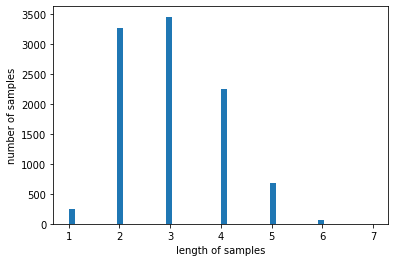

In [19]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [21]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4987
개체명 태깅 정보 집합의 크기 : 51


In [22]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [23]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [24]:
print(X_data[0])
print(y_data[0])

[2328, 32]
[1, 1]


In [25]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [26]:
print(index_to_ner)

{1: 'Other', 2: 'Type', 3: 'Amps', 4: 'Material', 5: 'Number of Poles', 6: 'Voltage', 7: 'Voltage Maximum', 8: 'Coil Voltage', 9: 'Phase', 10: 'Size', 11: 'Color', 12: '3 Phase Drive Horsepower Rating', 13: 'Length', 14: 'Speed Rating', 15: 'Trade Size', 16: 'Application', 17: 'Cable Type', 18: 'NEMA', 19: 'Connector Type', 20: 'Height', 21: 'Drive Size', 22: 'Depth', 23: 'Drive', 24: 'Installation', 25: 'Width', 26: 'Point', 27: 'Socket Depth', 28: 'Assembly Type', 29: 'Overload Relay', 30: 'Lamp Type', 31: 'Stud Holes', 32: 'Diameter', 33: 'Fixture Type', 34: 'Watts', 35: 'Conductor Type', 36: 'Legend - Number', 37: 'Capacity', 38: 'Category', 39: 'Grade', 40: 'Conductor Count', 41: 'Label Width', 42: 'Use With', 43: 'Product Type', 44: 'Tester Type', 45: 'Mounting Size', 46: 'Grit/ANSI Type', 47: 'For Use With', 48: 'Additional Detail', 49: 'Edge Thickness', 50: 'Container Size', 0: 'PAD'}


In [27]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['diversibit', 'kit']
디코딩 문장 : ['diversibit', 'kit']


In [28]:
max_len = 7
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [29]:
print(X_data.shape)
print(y_data.shape)

(10000, 7)
(10000, 7)


In [30]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.2, random_state=777)

In [31]:
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [32]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (8000, 7)
훈련 샘플 레이블(정수 인코딩)의 크기 : (8000, 7)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (8000, 7, 51)
테스트 샘플 문장의 크기 : (2000, 7)
테스트 샘플 레이블(정수 인코딩)의 크기 : (2000, 7)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (2000, 7, 51)


# char 정보를 사용하기 위한 추가 전처리

In [33]:
# char_vocab 만들기
words = list(set(data["Word"].values))
chars = set([w_i for w in words for w_i in w])
chars = sorted(list(chars))
print(chars)

['#', '&', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [34]:
char_to_index = {c: i + 2 for i, c in enumerate(chars)}
char_to_index["OOV"] = 1
char_to_index["PAD"] = 0

In [35]:
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [36]:
print(sentences[0])

['diversibit', 'kit']


In [37]:
max_len_char = 16

def padding_char_indice(char_indice, max_len_char):
  return pad_sequences(
        char_indice, maxlen=max_len_char, padding='post', value = 0)

def integer_coding(sentences):
  char_data = []
  for ts in sentences:
    word_indice = [word_to_index[t] for t in ts]
    char_indice = [[char_to_index[char] for char in t]  
                                          for t in ts]
    char_indice = padding_char_indice(char_indice, max_len_char)

    for chars_of_token in char_indice:
      if len(chars_of_token) > max_len_char:
        continue
    char_data.append(char_indice)
  return char_data

In [38]:
X_char_data = integer_coding(sentences)

In [39]:
X_char_data

[array([[22, 27, 40, 23, 36, 37, 27, 20, 27, 38,  0,  0,  0,  0,  0,  0],
        [29, 27, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 array([[ 9, 26, 33, 30, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [30, 39, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 array([[ 9, 13,  6, 10, 13, 27, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [32, 43, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [21, 19, 20, 30, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [38, 27, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 array([[ 9,  5,  9,  7, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [37, 38, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [30,  7, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [21, 33, 32, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 array([[ 9, 16, 27, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [31, 19, 25,  0,  0,  

In [40]:
# 정수 인코딩 이전의 기존 문장
print(sentences[0])

['diversibit', 'kit']


In [41]:
print(X_data[0])

[2328   32    0    0    0    0    0]


In [42]:
print(X_char_data[0])

[[22 27 40 23 36 37 27 20 27 38  0  0  0  0  0  0]
 [29 27 38  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [43]:
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value = 0)

In [44]:
X_char_train, X_char_test, _, _ = train_test_split(X_char_data, y_data, test_size=.2, random_state=777)

In [45]:
X_char_train = np.array(X_char_train)
X_char_test = np.array(X_char_test)

In [46]:
print(X_train[0])

[2098 1031   97    0    0    0    0]


In [47]:
print(index_to_word[150])

door


In [48]:
print(X_char_train[0])

[[24 30 32 25 22  0  0  0  0  0  0  0  0  0  0  0]
 [30 27 22  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [23 32 21 30 33 37 39 36 23  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [49]:
print(X_char_train[0][0])

[24 30 32 25 22  0  0  0  0  0  0  0  0  0  0  0]


In [50]:
print(' '.join([index_to_char[index] for index in X_char_train[0][0]]))

f l n g d PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD


In [51]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('훈련 샘플 char 데이터의 크기 : {}'.format(X_char_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (8000, 7)
훈련 샘플 레이블의 크기 : (8000, 7, 51)
훈련 샘플 char 데이터의 크기 : (8000, 7, 16)
테스트 샘플 문장의 크기 : (2000, 7)
테스트 샘플 레이블의 크기 : (2000, 7, 51)


# BiLSTM을 이용한 개체명 인식

## 모델링

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

In [53]:
embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         638336    
                                                                 
 bidirectional (Bidirectiona  (None, None, 512)        788480    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, None, 51)         26163     
 ibuted)                                                         
                                                                 
Total params: 1,452,979
Trainable params: 1,452,979
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.1)

Epoch 1/6
57/57 [==============================] - 8s 76ms/step - loss: 1.2112 - accuracy: 0.4655 - val_loss: 0.8212 - val_accuracy: 0.5236
Epoch 2/6
57/57 [==============================] - 3s 50ms/step - loss: 0.7271 - accuracy: 0.5469 - val_loss: 0.6737 - val_accuracy: 0.5889
Epoch 3/6
57/57 [==============================] - 3s 50ms/step - loss: 0.5736 - accuracy: 0.6444 - val_loss: 0.5968 - val_accuracy: 0.6148
Epoch 4/6
57/57 [==============================] - 3s 49ms/step - loss: 0.4837 - accuracy: 0.6886 - val_loss: 0.5469 - val_accuracy: 0.6501
Epoch 5/6
57/57 [==============================] - 3s 48ms/step - loss: 0.4143 - accuracy: 0.7236 - val_loss: 0.5014 - val_accuracy: 0.6768
Epoch 6/6
57/57 [==============================] - 3s 49ms/step - loss: 0.3503 - accuracy: 0.7623 - val_loss: 0.4799 - val_accuracy: 0.6965


In [56]:
model.save('bilstm.h5')

In [57]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 1s 1s/step
단어             |실제값  |예측값
-----------------------------------
24v              : Other   Other
motor            : Other   Type
oprtr            : Other   Other


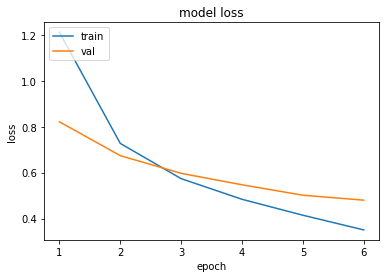

In [58]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
from seqeval.metrics import f1_score, classification_report

In [60]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [61]:
y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

63/63 [==============================] - 2s 8ms/step


In [62]:
print(classification_report(test_tags, pred_tags))

C:\Users\xx07230\Anaconda3\envs\smart_warehouse\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\xx07230\Anaconda3\envs\smart_warehouse\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Material seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\xx07230\Anaconda3\envs\smart_warehouse\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Type seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\xx07230\Anaconda3\envs\smart_warehouse\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Voltage seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\xx07230\Anaconda3\envs\smart_warehouse\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Color seems not to be NE tag.
 

                                precision    recall  f1-score   support

                        Number       0.33      0.33      0.33         3
 Phase Drive Horsepower Rating       0.93      0.91      0.92        74
                           EMA       0.00      0.00      0.00        46
                    abel Width       0.00      0.00      0.00         4
                     able Type       0.00      0.03      0.00        31
                      amp Type       0.00      0.00      0.00        16
                       apacity       0.00      0.00      0.00         5
                       ategory       0.00      0.00      0.00         5
                       aterial       0.36      0.29      0.32       103
                          atts       0.00      0.00      0.00        10
                 dge Thickness       0.00      0.00      0.00         1
                         eight       0.18      0.16      0.17        31
                         ength       0.57      0.06      0.11  

## 성능

In [63]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 39.6%


# BiLSTM-CRF를 이용한 개체명인식

## 모델링

In [64]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel
from seqeval.metrics import f1_score, classification_report

In [65]:
embedding_dim = 128
hidden_units = 64
dropout_ratio = 0.3

sequence_input = Input(shape=(max_len,),dtype=tf.int32, name='sequence_input')

model_embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len)(sequence_input)

model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)

model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)

model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')
model.summary()

Model: "crf_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_input (InputLayer)    [(None, 7)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 7, 128)       638336      ['sequence_input[0][0]']         
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 7, 128)      98816       ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 7, 128)      0           ['bidirectional_1[0][0]']

In [66]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

In [67]:
history = model.fit(X_train, y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
55/57 [===========================>..] - ETA: 0s - decode_sequence_accuracy: 0.6158 - loss: 16.1751
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.75946, saving model to bilstm_crf\cp.ckpt
57/57 [==============================] - 6s 40ms/step - decode_sequence_accuracy: 0.6183 - loss: 15.7585 - val_decode_sequence_accuracy: 0.7595 - val_loss: 7.0782
Epoch 2/15
55/57 [===========================>..] - ETA: 0s - decode_sequence_accuracy: 0.7781 - loss: 6.1269
Epoch 2: val_decode_sequence_accuracy improved from 0.75946 to 0.79607, saving model to bilstm_crf\cp.ckpt
57/57 [==============================] - 1s 26ms/step - decode_sequence_accuracy: 0.7785 - loss: 6.1052 - val_decode_sequence_accuracy: 0.7961 - val_loss: 6.0539
Epoch 3/15
57/57 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.8136 - loss: 5.3287
Epoch 3: val_decode_sequence_accuracy improved from 0.79607 to 0.80571, saving model to bilstm_crf\cp.ckpt
57/57 [===================

In [68]:
model.load_weights('bilstm_crf/cp.ckpt')

In [69]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]]))[0] # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 1s 592ms/step
단어             |실제값  |예측값
-----------------------------------
24v              : Other   Other
motor            : Other   Other
oprtr            : Other   Other


In [70]:
y_predicted = model.predict(X_test)[0]

63/63 [==============================] - 0s 3ms/step


In [71]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [72]:
def sequences_to_tag_for_crf(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            # pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            pred_index = pred
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [73]:
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

In [74]:
print(classification_report(test_tags, pred_tags))

                                precision    recall  f1-score   support

                        Number       0.00      0.00      0.00         3
 Phase Drive Horsepower Rating       0.89      0.95      0.92        74
                           EMA       0.61      0.30      0.41        46
                    abel Width       0.00      0.00      0.00         4
                     able Type       0.76      0.61      0.68        31
                      amp Type       0.00      0.00      0.00        16
                       apacity       0.00      0.00      0.00         5
                       ategory       1.00      0.60      0.75         5
                       aterial       0.41      0.36      0.38       103
                          atts       0.00      0.00      0.00        10
                 dge Thickness       0.00      0.00      0.00         1
                         eight       0.54      0.45      0.49        31
                         ength       0.47      0.41      0.44  

## 성능

In [75]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 60.1%


# BiLSTM-CNN을 이용한 개체명인식

## 모델링

In [76]:
from tensorflow.keras.layers import Embedding, Input, TimeDistributed, Dropout, concatenate, Bidirectional, LSTM, Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from seqeval.metrics import f1_score, classification_report

In [77]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

# 단어 임베딩
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(words_input)

# char 임베딩
character_input = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same', activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(dropout_ratio)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='softmax'))(output)

model = Model(inputs=[words_input, character_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='nadam',  metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, 16)]   0           []                               
                                                                                                  
 char_embedding (TimeDistribute  (None, None, 16, 64  2880       ['char_input[0][0]']             
 d)                             )                                                                 
                                                                                                  
 dropout_1 (Dropout)            (None, None, 16, 64  0           ['char_embedding[0][0]']         
                                )                                                                 
                                                                                            

In [78]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [79]:
history = model.fit([X_train, X_char_train], y_train, batch_size=128, epochs=15, validation_split=0.1, verbose=1, callbacks=[es, mc])

Epoch 1/15
56/57 [============================>.] - ETA: 0s - loss: 1.2040 - acc: 0.7144
Epoch 1: val_acc improved from -inf to 0.77018, saving model to bilstm_cnn.h5
57/57 [==============================] - 9s 109ms/step - loss: 1.2028 - acc: 0.7145 - val_loss: 0.8186 - val_acc: 0.7702
Epoch 2/15
56/57 [============================>.] - ETA: 0s - loss: 0.7463 - acc: 0.7968
Epoch 2: val_acc improved from 0.77018 to 0.81000, saving model to bilstm_cnn.h5
57/57 [==============================] - 6s 106ms/step - loss: 0.7456 - acc: 0.7969 - val_loss: 0.6745 - val_acc: 0.8100
Epoch 3/15
56/57 [============================>.] - ETA: 0s - loss: 0.5956 - acc: 0.8381
Epoch 3: val_acc improved from 0.81000 to 0.84321, saving model to bilstm_cnn.h5
57/57 [==============================] - 6s 107ms/step - loss: 0.5958 - acc: 0.8380 - val_loss: 0.5760 - val_acc: 0.8432
Epoch 4/15
56/57 [============================>.] - ETA: 0s - loss: 0.5060 - acc: 0.8630
Epoch 4: val_acc improved from 0.84321 to

In [80]:
model = load_model('bilstm_cnn.h5')

In [81]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 0s 471ms/step
단어             |실제값  |예측값
-----------------------------------
24v              : Other   Other
motor            : Other   Other
oprtr            : Other   Other


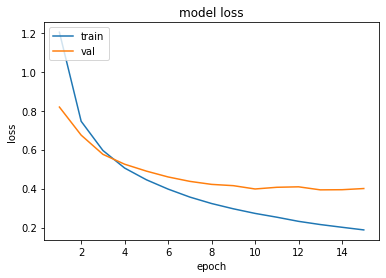

In [82]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [83]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [84]:
y_predicted = model.predict([X_test, X_char_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

63/63 [==============================] - 1s 11ms/step


In [85]:
print(classification_report(test_tags, pred_tags))

                                precision    recall  f1-score   support

                        Number       1.00      1.00      1.00         3
 Phase Drive Horsepower Rating       0.92      0.93      0.93        74
                           EMA       0.65      0.37      0.47        46
                    abel Width       1.00      0.50      0.67         4
                     able Type       0.80      0.65      0.71        31
                      amp Type       0.00      0.00      0.00        16
                       apacity       0.67      0.40      0.50         5
                       ategory       1.00      1.00      1.00         5
                       aterial       0.43      0.43      0.43       103
                          atts       0.00      0.00      0.00        10
                 dge Thickness       0.00      0.00      0.00         1
                         eight       0.37      0.35      0.36        31
                         ength       0.64      0.35      0.45  

## 성능

In [86]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 63.2%


#BiLSTM-CNN-CRF를 이용한 개체명인식

## 모델링

In [87]:
import tensorflow as tf
from keras_crf import CRFModel

In [88]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

# 단어 임베딩
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(words_input)

# char 임베딩
character_input = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(dropout_ratio)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[words_input, character_input], outputs=[output])
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')
model.summary()

Model: "crf_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, 16)]   0           []                               
                                                                                                  
 char_embedding (TimeDistribute  (None, None, 16, 64  2880       ['char_input[0][0]']             
 d)                             )                                                                 
                                                                                                  
 dropout_3 (Dropout)            (None, None, 16, 64  0           ['char_embedding[0][0]']         
                                )                                                                 
                                                                                        

In [89]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

In [90]:
history = model.fit([X_train, X_char_train], y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
57/57 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.6998 - loss: 9.0727
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.77107, saving model to bilstm_cnn_crf\cp.ckpt
57/57 [==============================] - 13s 156ms/step - decode_sequence_accuracy: 0.6998 - loss: 9.0115 - val_decode_sequence_accuracy: 0.7711 - val_loss: 6.4336
Epoch 2/15
57/57 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.7985 - loss: 5.5023
Epoch 2: val_decode_sequence_accuracy improved from 0.77107 to 0.81054, saving model to bilstm_cnn_crf\cp.ckpt
57/57 [==============================] - 9s 150ms/step - decode_sequence_accuracy: 0.7985 - loss: 5.4920 - val_decode_sequence_accuracy: 0.8105 - val_loss: 5.5045
Epoch 3/15
57/57 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.8326 - loss: 4.6089
Epoch 3: val_decode_sequence_accuracy improved from 0.81054 to 0.82768, saving model to bilstm_cnn_crf\cp.ckpt
57/57 [======

In [91]:
model.load_weights('bilstm_cnn_crf/cp.ckpt')

In [92]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0] 
true = np.argmax(y_test[i], -1) # 원-핫 벡터를 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 1s 760ms/step
단어             |실제값  |예측값
-----------------------------------
24v              : Other   Other
motor            : Other   Other
oprtr            : Other   Other


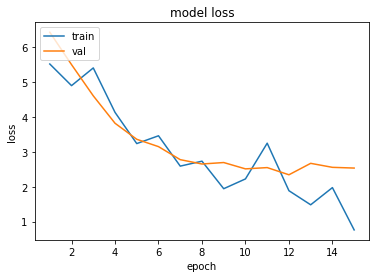

In [93]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [94]:
y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

63/63 [==============================] - 1s 14ms/step


In [95]:
print(classification_report(test_tags, pred_tags))

                                precision    recall  f1-score   support

                        Number       0.00      0.00      0.00         3
 Phase Drive Horsepower Rating       0.93      0.92      0.93        74
                           EMA       0.69      0.39      0.50        46
                    abel Width       0.00      0.00      0.00         4
                     able Type       0.80      0.65      0.71        31
                      amp Type       0.33      0.06      0.11        16
                       apacity       0.00      0.00      0.00         5
                       ategory       1.00      0.80      0.89         5
                       aterial       0.49      0.42      0.45       103
                          atts       0.20      0.10      0.13        10
                 dge Thickness       0.00      0.00      0.00         1
                         eight       0.64      0.45      0.53        31
                         ength       0.47      0.32      0.38  

## 성능

In [96]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 64.0%


# BiLSTM-BiLSTM-CRF을 이용한 개체명 인식

## 모델링

In [97]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.3
hidden_units = 64

word_ids = Input(batch_shape=(None, None), dtype='int32', name='word_input')
word_embeddings = Embedding(input_dim=vocab_size,
                                        output_dim=embedding_dim,
                                        name='word_embedding')(word_ids)

char_ids = Input(batch_shape=(None, None, None), dtype='int32', name='char_input')
char_embeddings = Embedding(input_dim=(len(char_to_index)),
                                        output_dim=char_embedding_dim,
                                        embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5),
                                        name='char_embedding')(char_ids)

char_embeddings = TimeDistributed(Bidirectional(LSTM(hidden_units)))(char_embeddings)
word_embeddings = concatenate([word_embeddings, char_embeddings])

word_embeddings = Dropout(dropout_ratio)(word_embeddings)
output = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(word_embeddings)
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[word_ids, char_ids], outputs=[output])
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

model.summary()

Model: "crf_model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 word_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 char_embedding (Embedding)     (None, None, None,   2880        ['char_input[0][0]']             
                                64)                                                               
                                                                                        

In [98]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

In [99]:
history = model.fit([X_train, X_char_train], y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
57/57 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.6825 - loss: 10.3233
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.77179, saving model to bilstm_bilstm_crf\cp.ckpt
57/57 [==============================] - 17s 193ms/step - decode_sequence_accuracy: 0.6825 - loss: 10.2567 - val_decode_sequence_accuracy: 0.7718 - val_loss: 6.5270
Epoch 2/15
57/57 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.7939 - loss: 5.6512
Epoch 2: val_decode_sequence_accuracy improved from 0.77179 to 0.80839, saving model to bilstm_bilstm_crf\cp.ckpt
57/57 [==============================] - 10s 175ms/step - decode_sequence_accuracy: 0.7939 - loss: 5.6709 - val_decode_sequence_accuracy: 0.8084 - val_loss: 5.5390
Epoch 3/15
57/57 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.8271 - loss: 4.8142
Epoch 3: val_decode_sequence_accuracy improved from 0.80839 to 0.82018, saving model to bilstm_bilstm_crf\cp.ckpt
5

In [100]:
model.load_weights('bilstm_bilstm_crf/cp.ckpt')

In [101]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0]
true = np.argmax(y_test[i], -1) # 원-핫 벡터를 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 1s 1s/step
단어             |실제값  |예측값
-----------------------------------
24v              : Other   Other
motor            : Other   Type
oprtr            : Other   Other


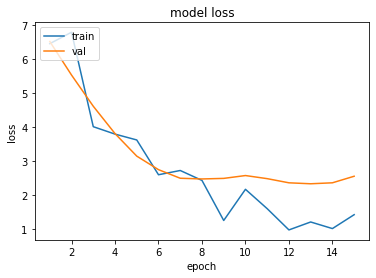

In [102]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [103]:
y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

63/63 [==============================] - 1s 23ms/step


In [106]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
def tags_classification_report(y_true, y_pred):
    
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
        
    tagset = set(lb.classes_) - {'O', 'PAD'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
    )
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
        
    tagset = set(lb.classes_) - {'O'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
    )

In [107]:
print(tags_classification_report(test_tags, pred_tags))

                                 precision    recall  f1-score   support

                Legend - Number       1.00      0.83      0.91         6
3 Phase Drive Horsepower Rating       0.96      0.96      0.96        77
                           Amps       0.82      0.78      0.80       145
                    Application       0.66      0.35      0.45        55
                  Assembly Type       0.93      0.72      0.81        18
                     Cable Type       0.84      0.73      0.78        49
                       Capacity       0.00      0.00      0.00         5
                       Category       1.00      1.00      1.00         5
                   Coil Voltage       0.87      0.85      0.86        73
                          Color       0.48      0.41      0.44        71
                Conductor Count       0.00      0.00      0.00         4
                 Conductor Type       0.88      0.70      0.78        10
                 Connector Type       0.64      0.

C:\Users\xx07230\Anaconda3\envs\smart_warehouse\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xx07230\Anaconda3\envs\smart_warehouse\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xx07230\Anaconda3\envs\smart_warehouse\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

## 성능

In [108]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 65.1%


C:\Users\xx07230\Anaconda3\envs\smart_warehouse\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\xx07230\Anaconda3\envs\smart_warehouse\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Material seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\xx07230\Anaconda3\envs\smart_warehouse\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Type seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\xx07230\Anaconda3\envs\smart_warehouse\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Voltage seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\xx07230\Anaconda3\envs\smart_warehouse\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Color seems not to be NE tag.
 